In [23]:
import torch
import torch.nn.functional as f
from torchvision import datasets, transforms
import torch.nn
import utils
import matplotlib.pyplot as plt


from model import get_model

device = torch.device("cpu")

In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),])

subset_size = 256
print(f"Evaluating on the first {subset_size} MNIST test samples")

test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_subset = torch.utils.data.Subset(test_dataset, range(subset_size))
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=subset_size, shuffle=False)

x_test, y_test = next(iter(test_loader))
x_test = x_test.view(x_test.size(0), -1).to(device)
y_test = y_test.to(device)

print(f"Loaded {x_test.shape[0]} samples")
print(f"Flattened dimension: {x_test.shape[1]}")
print(f"Data range: {x_test.min():.3f} to {x_test.max():.3f}")

Evaluating on the first 256 MNIST test samples
Loaded 256 samples
Flattened dimension: 784
Data range: 0.000 to 1.000


In [25]:
model = get_model(pretrained_path="data/model.pth", device=device)
clean_accuracy = utils.accuracy(model, x_test, y_test)

In [26]:
attack_results = {}

def clamp_unit(x):
    return torch.clamp(x, 0.0, 1.0)

def project_linf(delta, eps):
    return torch.clamp(delta, -eps, eps)

def compute_attack_metrics(x_adv, x_clean=x_test, y_clean=y_test):
    with torch.no_grad():
        adv_logits = model(x_adv)
        adv_preds = adv_logits.argmax(dim=1)
    adv_acc = (adv_preds == y_clean).float().mean().item()
    delta = x_adv - x_clean
    linf = delta.abs().max(dim=1)[0].mean().item()
    l2 = torch.norm(delta, p=2, dim=1).mean().item()
    return adv_acc, linf, l2

def log_attack(name, x_adv, notes=None):
    adv_acc, linf, l2 = compute_attack_metrics(x_adv)
    attack_results[name] = {
        "clean_acc": clean_accuracy,
        "adv_acc": adv_acc,
        "avg_linf": linf,
        "avg_l2": l2,
        "notes": notes or ""
    }
    print(f"{name} -> adv accuracy: {adv_acc:.4f} | mean L_inf: {linf:.4f} | mean L2: {l2:.4f}")

def visualize_examples(name, x_adv, num_examples=5):
    num_examples = min(num_examples, x_adv.size(0))
    clean_imgs = x_test[:num_examples].detach().cpu().reshape(-1, 28, 28)
    adv_imgs = x_adv[:num_examples].detach().cpu().reshape(-1, 28, 28)
    diff = adv_imgs - clean_imgs
    vmax = diff.abs().max().item() or 1.0
    fig, axes = plt.subplots(3, num_examples, figsize=(num_examples * 2.2, 6))
    for idx in range(num_examples):
        axes[0, idx].imshow(clean_imgs[idx], cmap="gray")
        axes[0, idx].set_title(f"Clean {idx}")
        axes[0, idx].axis("off")

        axes[1, idx].imshow(adv_imgs[idx], cmap="gray")
        axes[1, idx].set_title("Adv")
        axes[1, idx].axis("off")

        axes[2, idx].imshow(diff[idx], cmap="seismic", vmin=-vmax, vmax=vmax)
        axes[2, idx].set_title("Perturb")
        axes[2, idx].axis("off")
    plt.suptitle(name)
    plt.tight_layout()
    plt.show()

In [27]:
eps = 0.03

def fgsm_attack(model, x, y, eps):
    x_adv=x.clone().detach().to(device)
    y = y.to(device)
    logits = model(x)
    loss = f.cross_entropy(logits, y)
    loss.backward()
    model.zero_grad()
    grad_sign = x_adv.data.sign()
    x_adv = x_adv + eps* grad_sign
    x_adv = torch.clamp(x_adv, 0.0, 1.0)
    return x_adv.detach()
    
    


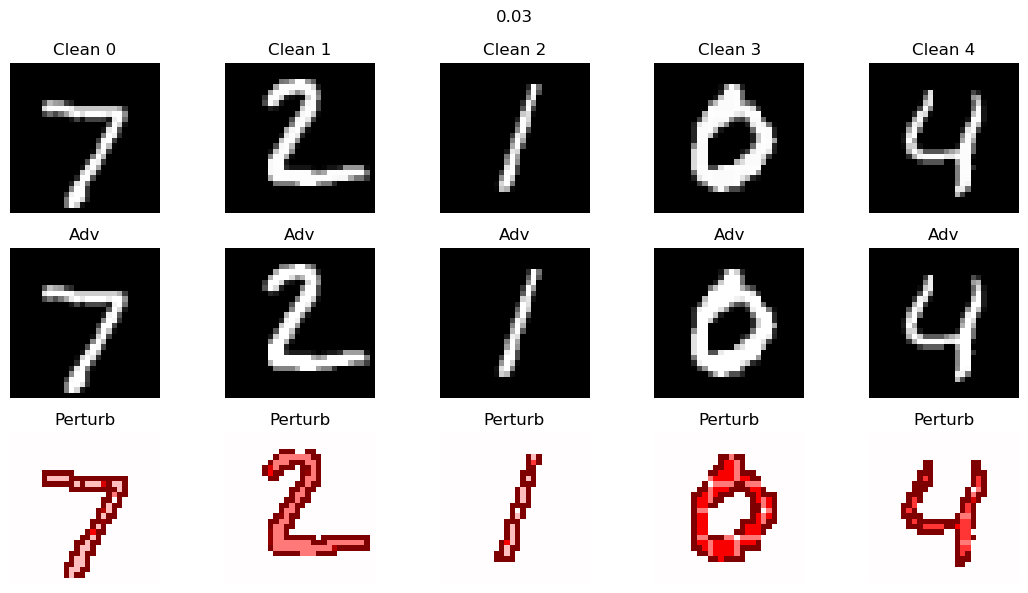

In [28]:
x_adv_fgsm_attack = fgsm_attack(model, x_test, y_test, eps)
visualize_examples(eps, x_adv_fgsm_attack)


In [29]:
eps = 0.03
alpha = 0.03
steps = 40

def bim_attack(model, x, y, eps, alpha, steps):
    x_adv = x.clone().detach()

    for _ in range(steps):
        x_adv.requires_grad_(True)
        logits = model(x)
        loss = f.cross_entropy(logits, y)
        loss.backward()
        model.zero_grad()

        grad_sign = x_adv.data.sign()
        x_adv = x_adv + alpha*grad_sign

        delta = torch.clamp(x_adv-x, -eps, eps)
        x_adv = torch.clamp(delta, 0.0, 1.0).detach()

        return x_adv


BIM (eps=0.03, alpha=0.03, steps=40) -> adv accuracy: 0.3125 | mean L_inf: 0.9695 | mean L2: 8.4192


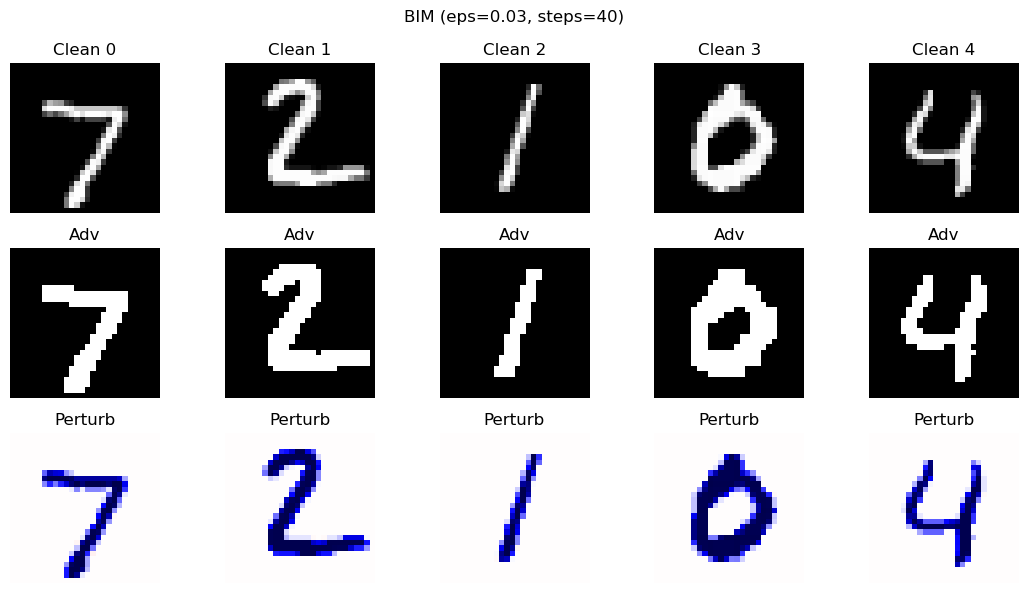

In [30]:
x_bim_attack = bim_attack(model, x_test, y_test, eps, alpha, steps)
log_attack(f"BIM (eps={eps}, alpha={alpha}, steps={steps})", x_bim_attack, notes="Iterative FGSM / Basic iterative attack")
visualize_examples(f"BIM (eps={eps}, steps={steps})", x_bim_attack)

In [31]:
eps = 0.03
alpha = 0.03
steps = 40
restarts = 5

def pgd_attack(model, x, y, eps, alpha, steps, restarts=1):
    best_adv = x.clone()
    best_losses = torch.full((x.size(0), ), -1e9, device = x.device)

    for _ in range(restarts):
        x_adv = x+ torch.empty_like(x).uniform_(eps, eps)
        x_adv = torch.clamp(x_adv, 0.0, 1.0)

        for _ in range(steps):
            x_adv.requires_grad_(True)
            logits = model(x_adv)
            loss = f.cross_entropy(logits, y)
            model.zero_grad()
            loss.backward()
    
            grad_sign = x_adv.data.sign()
            x_adv = x_adv + alpha* grad_sign
    
            delta = torch.clamp(x_adv-x, -eps, eps)
            x_adv = torch.clamp(delta, 0.0, 1.0).detach()
    
        with torch.no_grad():
            logits = model(x_adv)
            losses = f.cross_entropy(logits, y, reduction = "none")
            mask = losses > best_losses 
            best_adv[mask] = x_adv[mask]
            best_losses[mask] = losses[mask]
    
        return best_adv

PGD (eps=0.03, steps=40, restarts=5) -> adv accuracy: 0.0625 | mean L_inf: 0.9995 | mean L2: 8.7631


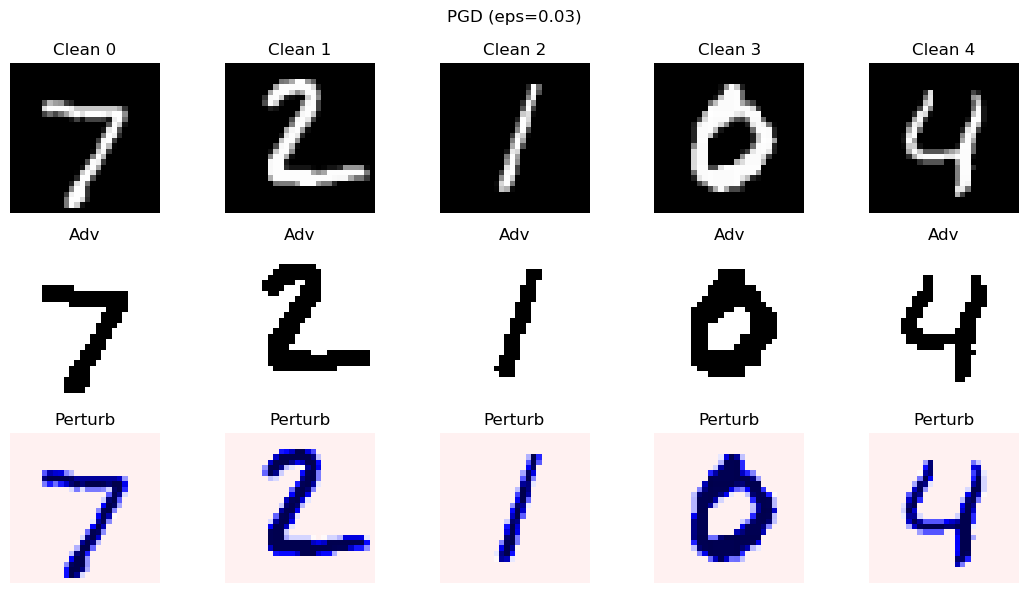

In [32]:
x_adv_pgd = pgd_attack(model, x_test, y_test, eps, alpha, steps, restarts)
log_attack(f"PGD (eps={eps}, steps={steps}, restarts={restarts})", x_adv_pgd, notes="Madry PGD with random restarts")
visualize_examples(f"PGD (eps={eps})", x_adv_pgd)

In [33]:
eps = 0.02
alpha = 0.2
steps = 40
restarts = 5

def pgd_attack_2(model, x, y, eps, alpha, steps, restarts):
    best_adv = x.clone()
    best_losses = torch.full((x.size(0), ), -1e9, device = x.device)

    for _  in range(restarts):
        x_adv = x + torch.empty_like(x).uniform_(-eps, eps)
        
        x_adv = torch.clamp(x_adv, -eps, eps)

        for _ in range(steps):
            x_adv.requires_grad_(True)
            logits = model(x_adv)
            loss = f.cross_entropy(logits, y)
            model.zero_grad()
            loss.backward()
            grad_sign = x_adv.data.sign()
            x_adv = x_adv + alpha*grad_sign
            delta = torch.clamp(x_adv-x, -eps, eps)
            x_adv = torch.clamp(delta, 0.0, 1.0).detach()

        with torch.no_grad():
            logits = model(x_adv)
            losses = f.cross_entropy(logits, y, reduction ="none")
            mask = losses >best_losses
            best_adv[mask] =x_adv[mask]
            best_losses = losses[mask]
        return x_adv

            

    

PGD (eps=0.02, steps=40, restarts=5) -> adv accuracy: 0.0859 | mean L_inf: 0.9995 | mean L2: 8.7315


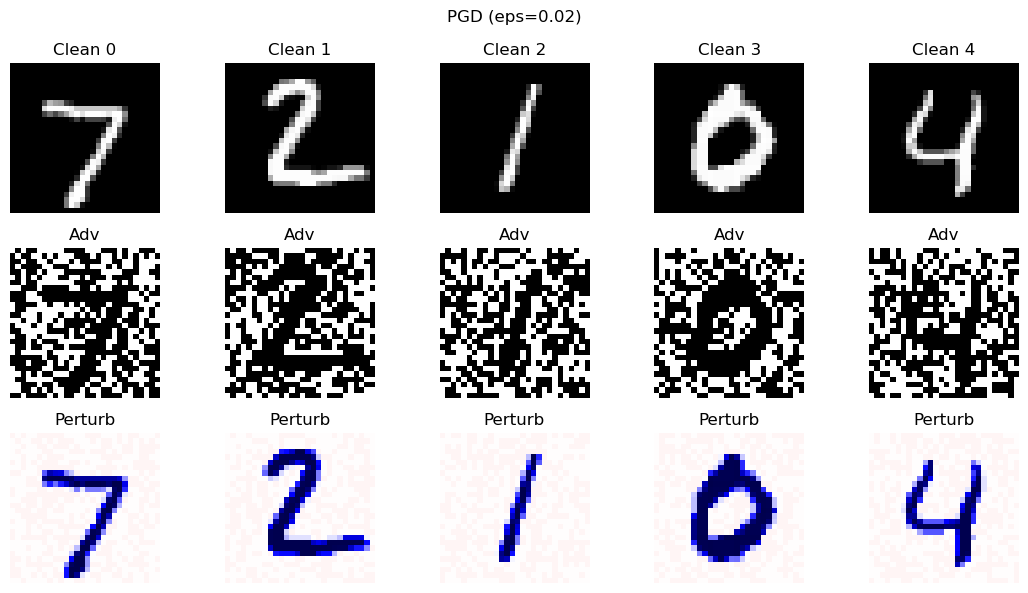

In [34]:
x_adv_pgd = pgd_attack_2(model, x_test, y_test, eps, alpha, steps, restarts)
log_attack(f"PGD (eps={eps}, steps={steps}, restarts={restarts})", x_adv_pgd, notes="Madry PGD with random restarts")
visualize_examples(f"PGD (eps={eps})", x_adv_pgd)

In [45]:
def arctanh(x):
    return 0.5 * torch.log((1 + x) / (1 - x))

def cw_l2_attack(model, x, y, c=1e-2, kappa=0.0, steps=250, lr=0.01):
    model.eval()
    x_orig = torch.clamp(x, 0.0, 1.0)
    x_scaled = x_orig * 2 - 1
    x_scaled = torch.clamp(x_scaled, -0.999999, 0.999999)
    w = arctanh(x_scaled)
    w = w.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([w], lr=lr)
    for step in range(steps):
        adv = torch.tanh(w) * 0.5 + 0.5
        logits = model(adv)
        one_hot = f.one_hot(y, num_classes=logits.shape[1]).float()
        real = torch.sum(one_hot * logits, dim=1)
        other = torch.max((1 - one_hot) * logits - one_hot * 1e4, dim=1)[0]
        F = torch.clamp(other - real + kappa, min=0)
        l2 = torch.sum((adv - x_orig) ** 2, dim=1)
        loss = (l2 + c * F).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (step + 1) % 50 == 0:
            print(f"step {step + 1}/{steps} - loss {loss.item():.4f}")
    adv = torch.tanh(w).detach() * 0.5 + 0.5
    return clamp_unit(adv)
        


step 50/200 - loss 0.0011
step 100/200 - loss 0.0011
step 150/200 - loss 0.0011
step 200/200 - loss 0.0011
Carlini-Wagner L2 -> adv accuracy: 0.9688 | mean L_inf: 0.0004 | mean L2: 0.0013


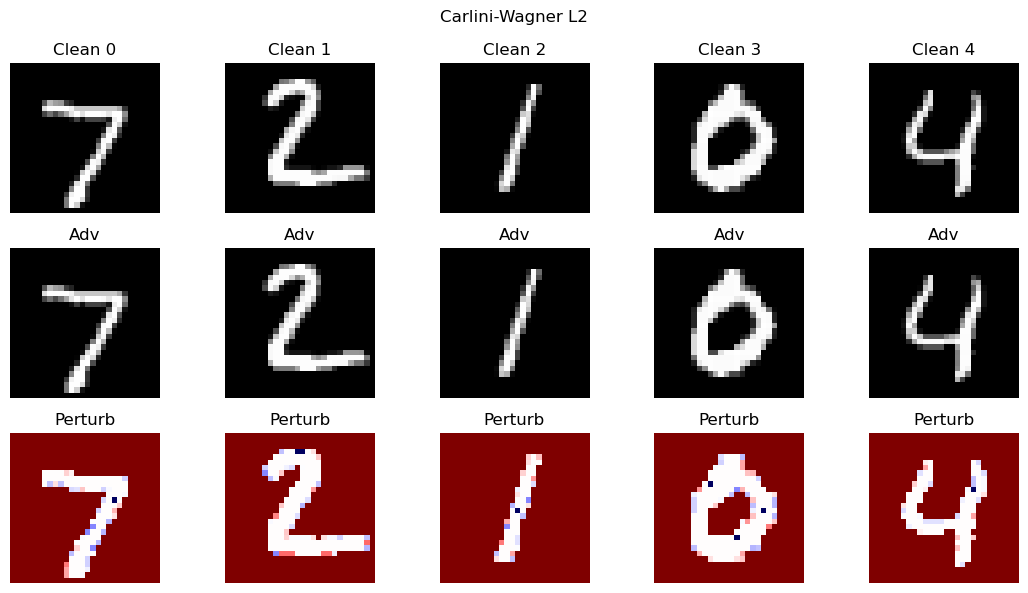

In [46]:

cw_params = {"c": 1e-2, "kappa": 0.0, "steps": 200, "lr": 0.01}
x_adv_cw = cw_l2_attack(model, x_test, y_test, **cw_params)
log_attack("Carlini-Wagner L2", x_adv_cw, notes=f"Params: {cw_params}")
visualize_examples("Carlini-Wagner L2", x_adv_cw)

In [53]:
def arctanh(x):
    return 0.5 *torch.log((1+x)/(1-x))

def cw_attack(model, x, y, c=1e9, kappa= 0.0, steps = 250, lr=0.0):
    model.eval()
    x_orig = torch.clamp(x, 0.0, 1.0)
    x_scaled = x_orig * 2 -1
    x_scaled = torch.clamp(x_scaled, -0.999999, 0.99999)

    w = arctanh(x_scaled)
    w= w.clone().detach().requires_grad_(True)

    for step in range(steps):
        adv = torch.tanh(w) * 0.5 + 0.5
        logits = model(adv)
        one_hot = f.one_hot(y, num_classes=logits.shape[1]).float()
        real = torch.sum(one_hot * logits, dim=1)
        other = torch.max((1-one_hot) * logits - one_hot * 1e4, dim=1) [0]
        F = torch.clamp(other - real + kappa, min =0)
        l2 = torch.sum((adv-x_orig) **2, dim=1)
        loss = (l2 + c *F ).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step+1) %50 == 0:
            print(f"step {step +1}/{steps}-loss {loss.item():.4f}")
        adv = torch.tanh(w).detach() * 0.5 + 0.5
        return torch.clamp(adv, 0.0,1.0)

step 50/200 - loss 0.0011
step 100/200 - loss 0.0011
step 150/200 - loss 0.0011
step 200/200 - loss 0.0011
Carlini-Wagner L2 -> adv accuracy: 0.9688 | mean L_inf: 0.0004 | mean L2: 0.0013


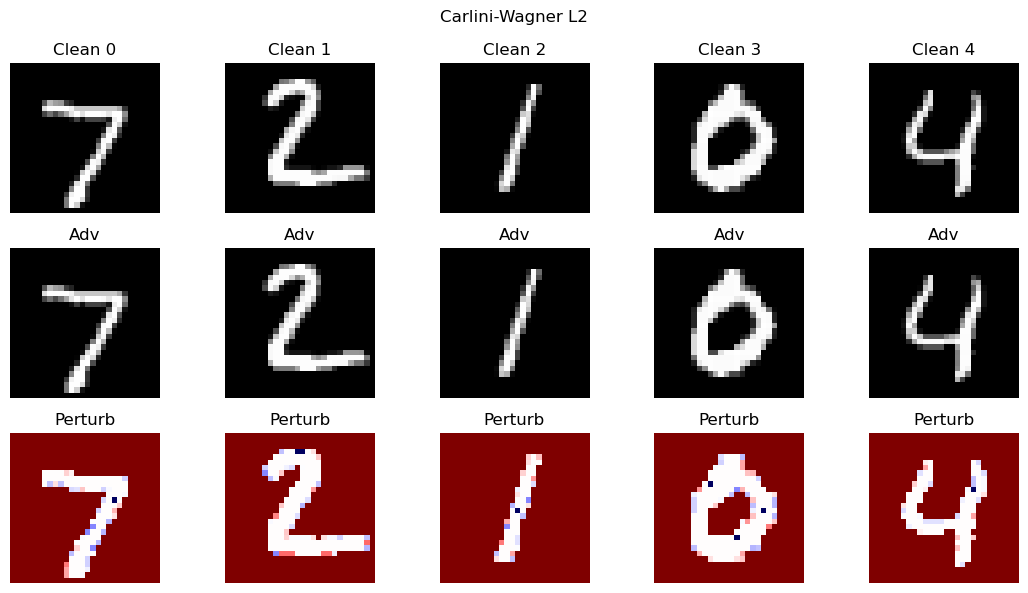

In [54]:
cw_params = {"c": 1e-2, "kappa": 0.0, "steps": 200, "lr": 0.01}
x_adv_cw = cw_l2_attack(model, x_test, y_test, **cw_params)
log_attack("Carlini-Wagner L2", x_adv_cw, notes=f"Params: {cw_params}")
visualize_examples("Carlini-Wagner L2", x_adv_cw)